# Worksheet - Classification (Part II)

## Learning Goals:

After completing this workshop session, you will be able to:

* Describe what a test data set is and how it is used in classification.
* Understand several ways of representing classifier performance: accuracy, precision, and recall, and the confusion matrix.
* Using Python, evaluate classifier performance using a test data set and appropriate metrics.
* Using Python, execute cross-validation in Python to choose the number of neighbours.
* Identify when it is necessary to scale variables before classification and do this using Python
* In a dataset with > 2 attributes, perform k-nearest neighbour classification in Python using the `scikit-learn` package to predict the class of a test dataset.
* Describe advantages and disadvantages of the k-nearest neighbour classification algorithm.

This worksheet covers parts of [Chapter 6](https://python.datasciencebook.ca/classification2) of the online textbook. You can refer to and read this chapter to help you answer the worksheet. Any place you see `___`, you must fill in the function, variable, or data to complete the code before running the cell.

In [1]:
### Run this cell before continuing.
import altair as alt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# Simplify working with large datasets in Altair
alt.data_transformers.disable_max_rows()

# Output dataframes instead of arrays
set_config(transform_output="pandas")

## 1. Fruit Data Example

In the agricultural industry, cleaning, sorting, grading, and packaging food products are all necessary tasks in the post-harvest process. Products are classified based on appearance, size and shape, attributes which helps determine the quality of the food. Sorting can be done by humans, but it is tedious and time consuming. Automatic sorting could help save time and money. Images of the food products are captured and analysed to determine visual characteristics. 

The [dataset](https://www.kaggle.com/mjamilmoughal/k-nearest-neighbor-classifier-to-predict-fruits/notebook) contains observations of fruit described with four features: (1) mass (in g), (2) width (in cm), (3) height (in cm), and (4) color score (on a scale from 0 - 1).

To get started building a classifier that can classfiy a fruit based on its appearance, use `pd.read_csv` to load the file `fruit_data.csv` (found in the data folder) from the previous tutorial into your notebook.

*Assign your data to an object called `fruit_data`.*

In [2]:
# Run this cell to read the data
fruit_data = pd.read_csv("data/fruit_data.csv")

Let's take a look at the first few observations in the fruit dataset. Run the cell below.

In [3]:
# Run this cell to preview the data
fruit_data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


Now let's investigate the class counts for each kind of fruit:

In [4]:
fruit_data['fruit_name'].value_counts(normalize=False)

fruit_name
apple       19
orange      19
lemon       16
mandarin     5
Name: count, dtype: int64

We can change to using `normalize=True` to get the class proportions:

In [5]:
fruit_data['fruit_name'].value_counts(normalize=True)

fruit_name
apple       0.322034
orange      0.322034
lemon       0.271186
mandarin    0.084746
Name: proportion, dtype: float64

## Randomness and Setting Seeds

This worksheet uses functions from the `scikit-learn` library, which not only allows us to perform K-nearest neighbour classification, but also allows us to evaluate how well our classification worked. In order to ensure that the steps in the worksheet are reproducible, we need to set a *`random_state`* or *random seed*, i.e., a numerical "starting value," which determines the sequence of random numbers Python will generate.

Below in many cells we have included an argument to set the `random_state` or `np.random.seed`. They are necessary to make sure the autotesting code functions properly. In your own analysis however, it is a better practice to set the *`random_state`* or *random seed* just once at the beginning of your script.

## 2. Splitting the data into a training and test set

In this exercise, we will be partitioning `fruit_data` into a training (75%) and testing (25%) set using the `scikit-learn` package. After creating the test set, we will put the test set away in a lock box and not touch it again until we have found the best k-nn classifier we can make using the training set. We will use the variable `fruit_name` as our class label. 


### Question 1

To create the training and test set, we would use the `train_test_split` function from `scikit-learn` package. Save the trained dataset and test dataset as `fruit_train` and `fruit_test`, respectively. To help you out, we have put a scaffold of the code in the cell below. Your job is to fill in the blanks with the correct values.

> Note: by default `scikit-learn` will **not** stratify the split by the label,
> so if we forget to set `stratify` to `fruit_data['fruit_name']` it could be possible that
> we may not end up with an observation in the test set with the label "mandarin"
> (because there are only 5 mandarin observations in the entire data set),
> and as a consequence, we would not be able to evaluate predictions on it...

In [6]:
# Split data into a training and test set

# fruit_train, fruit_test = train_test_split(____, 
#                                            test_size=____,
#                                            stratify=____,
#                                            random_state=____) # set the random state to be 2020
### BEGIN SOLUTION
fruit_train, fruit_test = train_test_split(fruit_data, 
                                           test_size=0.25,
                                           stratify=fruit_data['fruit_name'],
                                           random_state=2020) # set the random state to be 2020
### END SOLUTION
fruit_train.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
25,3,orange,spanish_jumbo,356,9.2,9.2,0.75
19,1,apple,cripps_pink,162,7.4,7.2,0.85
2,1,apple,granny_smith,176,7.4,7.2,0.60
57,4,lemon,unknown,152,6.5,8.5,0.72
17,1,apple,golden_delicious,168,7.5,7.6,0.73


In [7]:
fruit_test.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
49,4,lemon,unknown,132,5.8,8.7,0.73
11,1,apple,braeburn,172,7.1,7.6,0.92
42,3,orange,turkey_navel,154,7.2,7.2,0.82
21,1,apple,cripps_pink,156,7.4,7.4,0.84
38,3,orange,turkey_navel,158,7.2,7.8,0.77


In [8]:
# Run these tests to check your answer

# Check training data 
assert isinstance(fruit_train, pd.DataFrame), "`fruit_train` is not a pandas DataFrame"
assert fruit_train.shape == (44, 7), f"Expected shape (44, 7), but got {fruit_train.shape}"
assert (fruit_train['fruit_name'] == 'mandarin').any(), "`mandarin` not found in `fruit_name`"
np.testing.assert_array_equal(np.array([14, 14, 12,  4]), fruit_train['fruit_name'].value_counts().values,
                             err_msg='Some unexpected observations are in your training set.')
assert fruit_train['fruit_name'].value_counts().index.tolist() == ['orange', 'apple', 'lemon', 'mandarin'], 'Some unexpected observations are in your training set.'

# Check test data
assert isinstance(fruit_test, pd.DataFrame), "`fruit_test` is not a pandas DataFrame"
assert fruit_test.shape == (15, 7), f"Expected shape (15, 7), but got {fruit_train.shape}"
assert (fruit_test['fruit_name'] == 'mandarin').any(), "`mandarin` not found in `fruit_name`"
np.testing.assert_array_equal(np.array([5, 5, 4, 1]), fruit_test['fruit_name'].value_counts().values,
                             err_msg='Some unexpected observations are in your test set.')
assert fruit_test['fruit_name'].value_counts().index.tolist() == ['apple', 'orange', 'lemon', 'mandarin'], 'Some unexpected observations are in your test set.'

print('Success!')

Success!


### Question 2 

K-nearest neighbors is sensitive to the scale of the predictors so we should do some preprocessing to standardize them. Remember that standardization is *part of your training procedure*, so you can't use your test data to compute the centered / scaled values for each variable. Once we have created the standardization preprocessor, we can then later on apply it separately to both the training and test data sets.

For this worksheet, let's see if `mass`, `width`, `height` and `color_score` can predict `fruit_name`. 

To scale and center the data, first, pass the predictors to the `make_column_transformer` function to make the preprocessor. To help you out, we have put a scaffold of the code in the cell below. Your job is to fill in the blanks with the correct values.

*Assign your answer to an object called `fruit_preprocessor`.*

In [9]:
# Create a preprocessor using the training data

# fruit_preprocessor = make_column_transformer(
#     (____, ____,
#     verbose_feature_names_out=____
# )
### BEGIN SOLUTION
fruit_preprocessor = make_column_transformer(
    (StandardScaler(), ['mass', 'width', 'height', 'color_score']),
    verbose_feature_names_out=False
)
### END SOLUTION
fruit_preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['mass', 'width', 'height', 'color_score'])],
                  verbose_feature_names_out=False)

In [10]:
# Run these tests to check your answer

assert isinstance(fruit_preprocessor, ColumnTransformer), "fruit_preprocessor is not a ColumnTransformer"
expected_columns = {'mass', 'width', 'height', 'color_score'}
actual_columns = set(fruit_preprocessor.transformers[0][2])
assert actual_columns == expected_columns, f"Expected columns {expected_columns}, but got {actual_columns}"
assert isinstance(fruit_preprocessor.transformers[0][1], StandardScaler), "Transformer is not an instance of StandardScaler"

print('Success!')

Success!


Now that we have split the data, we can do things like exploratory data analysis and model fitting!!!

A common way to explore the data when peforming classification is to create pairwise plots of the predictor variables,
and color the points by the class label. Remember, that our model is sensitive to scale, 
and so we should also scale the data when visualizing it for modeling insights.

In [11]:
# Run this cell to scale the data and create a pairwise scatter plot

# Create a scaled version of the data
fruit_preprocessor.fit(fruit_train)
scaled_fruit_train = fruit_preprocessor.transform(fruit_train)

# Create the scatterplot
fruit_pairwise = alt.Chart(fruit_train).mark_point(filled=True, stroke='black', strokeWidth=0.5, size=75, opacity=0.9).encode(
    x=alt.X(alt.repeat("column"), type='quantitative'),
    y=alt.Y(alt.repeat("row"), type='quantitative'),
    color=alt.Color("fruit_name:N", scale=alt.Scale(range=['green', 'yellow', '#f26a02', '#ffd1a6'])),
    shape=alt.Shape("fruit_name:N", scale=alt.Scale(range=['circle', 'diamond', 'circle', 'square'])),
).properties(
    width=175,
    height=175
).repeat(
    row=['mass', 'width', 'height', 'color_score'],
    column=['color_score', 'height','width', 'mass']
).interactive()

fruit_pairwise

alt.RepeatChart(...)

## 3. Cross-validation and parameter value selection

### Question 3

We want to pick the number of neighbours to maximize the performance of our classifier on data *it hasn’t seen yet*. One way to do this is to cross-validation. To do this in Python we should do the following:

1. Setup a pipeline object that specifies the data and preprocessor, as well as the type of model we want to use,
2. Create a dictionary with the range of values we want to search through for the parameter(s)
3. Pass the pipline object, and parameter grid dictionary object to a `GridSearchCV`.
4. Run `fit` on the `GridSearchCV` object to carryout the tuning process.
5. Use `pd.DataFrame` to convert the output to a dataframe for convenience.

Perform the above using to run **4-fold** cross validation to choose $K$ 
for K-nearest neighbors classification.
Use the `fruit_preprocessor` object you created in question 2,
and search across the values from 1 to 15 (incrementing by 1).

*Assign your final data frame to an object called `fruit_vfold_score` so you can check your work.*

In [12]:
np.random.seed(2020)  # DO NOT REMOVE

# # 1. Setup pipeline object
# fruit_tune_pipeline = make_pipeline(____, 
#                                     ____)
# 
# # 2. Define parameter grid
# parameter_grid = {
#     ____: range(____, ____, ____),
# }
# 
# # 3. Create `GridSearchCV` object
# fruit_tune_grid = GridSearchCV(
#     estimator=____,
#     param_grid=____,
#     cv=____
# )
# 
# # 4. Fit `GridSearchCV` object
# fruit_tune_grid.fit(
#     ____,
#     ____
# )
# 
# # 5. Convert results to data frame
# fruit_vfold_score = pd.DataFrame(____)
# ### BEGIN SOLUTION
# 1. Setup pipeline object
fruit_tune_pipeline = make_pipeline(fruit_preprocessor, 
                                    KNeighborsClassifier())

# 2. Define parameter grid
parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 15, 1),
}

# 3. Create `GridSearchCV` object
fruit_tune_grid = GridSearchCV(
    estimator=fruit_tune_pipeline,
    param_grid=parameter_grid,
    cv=4
)

# 4. Fit `GridSearchCV` object
fruit_tune_grid.fit(
    fruit_train.drop(columns=['fruit_name']),
    fruit_train['fruit_name']
)

# 5. Convert results to data frame
fruit_vfold_score = pd.DataFrame(fruit_tune_grid.cv_results_)
### END SOLUTION
fruit_vfold_score.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004417,0.001260,0.003736,0.000423,1,{'kneighborsclassifier__n_neighbors': 1},0.818182,0.818182,1.000000,1.000000,0.909091,0.090909,3
1,0.003344,0.000198,0.003084,0.000259,2,{'kneighborsclassifier__n_neighbors': 2},0.727273,0.818182,1.000000,1.000000,0.886364,0.118094,4
2,0.008546,0.008568,0.006446,0.006219,3,{'kneighborsclassifier__n_neighbors': 3},0.909091,0.909091,1.000000,0.909091,0.931818,0.039365,1
3,0.022629,0.028549,0.005435,0.002155,4,{'kneighborsclassifier__n_neighbors': 4},0.727273,1.000000,1.000000,1.000000,0.931818,0.118094,1
4,0.004683,0.000304,0.004403,0.000543,5,{'kneighborsclassifier__n_neighbors': 5},0.727273,0.909091,0.909091,1.000000,0.886364,0.099066,4


In [13]:
fruit_vfold_score['rank_test_score'].value_counts()

rank_test_score
4     3
1     2
9     2
3     1
7     1
8     1
12    1
11    1
14    1
13    1
Name: count, dtype: int64

In [14]:
# Run these tests to check your answer

assert isinstance(fruit_vfold_score, pd.DataFrame), "`fruit_test` is not a pandas DataFrame"
assert fruit_vfold_score.shape == (14, 13), f"Expected shape (14, 13), but got {fruit_vfold_score.shape}"
expected_columns = {'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_kneighborsclassifier__n_neighbors', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'}
actual_columns = set(fruit_vfold_score.columns)
assert actual_columns == expected_columns, f"Expected columns {expected_columns}, but got {actual_columns}"

np.testing.assert_array_equal(np.array([3, 2, 2, 1, 1, 1, 1, 1, 1, 1]), fruit_vfold_score['rank_test_score'].value_counts().values,
                             err_msg='Something unexpected happened with the tuning of your classifier. Check your model and cross-validation specs.')
assert fruit_vfold_score['rank_test_score'].value_counts().index.tolist() == [4, 1, 9, 3, 7, 8, 12, 11, 14, 13], 'Something unexpected happened with the tuning of your classifier. Check your model and cross-validation specs.'

print('Success!')

Success!


To make the results a bit easier to interpret, 
let's select just the columns we are interested in:

- `param_kneighborsclassifier__n_neighbors`
- `mean_test_score`

In [15]:
# Run this cell to see a table of just the parameter values and
# the mean cross-validation accuracy

fruit_vfold_score[['param_kneighborsclassifier__n_neighbors',
                  'mean_test_score']]

,param_kneighborsclassifier__n_neighbors,mean_test_score
0,1,0.909091
1,2,0.886364
2,3,0.931818
3,4,0.931818
4,5,0.886364
5,6,0.886364
6,7,0.863636
7,8,0.795455
8,9,0.704545
9,10,0.704545


### Visualizing a parameter's effect on model performance

Visually inspecting the grid search results can help us find, 
and choose the best value for the number of neighbors parameter.

Below, we use `altair` (a Python visualization library) 
to create a line plot using the `accuracies_grid` dataframe 
with `param_kneighborsclassifier__n_neighbors` on the x-axis 
and the `mean_test_score` on the y-axis. Use `point=True` to include a point for each value of $K$. 

In [16]:
# Run this cell to visualize the parameters vs mean cross-validation accuracy 
# as a line chart

accuracy_versus_k_grid = alt.Chart(fruit_vfold_score).mark_line(point=True).encode(
    x=alt.X("param_kneighborsclassifier__n_neighbors")
        .title("Neighbors")
        .scale(zero=False),
    y=alt.Y("mean_test_score")
        .title("Mean Test Score")
        .scale(zero=False)
)

accuracy_versus_k_grid

alt.Chart(...)

## 6. Understanding prediction errors

Now, let's look at the *confusion matrix* for the classifier. This will show us a table comparing the predicted labels with the true labels. 

Although we can create a confusion matrix by using the `crosstab` function from `pandas`, with many observations, it can be difficult to interpret the confusion matrix when it is presented as a table like above. In these cases, we could instead use the `ConfusionMatrixDisplay` function of the `scikit-learn` package to visualize the confusion matrix as a heatmap. Please run the cell below to see the fruit confusion matrix as a heatmap. 

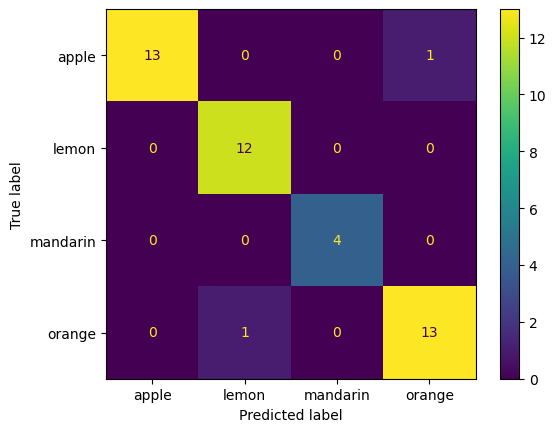

In [17]:
ConfusionMatrixDisplay.from_estimator(
    estimator=fruit_tune_grid,  # We are directly passing the pipeline and let sklearn do the predictions for us
    X=fruit_train.drop(columns=['fruit_name']),
    y=fruit_train['fruit_name']
)

What mistakes is it making? 
Revisit the pairwise scatter plot you created after question 2, 
can you guess why its making these mistakes? 
Do you have any ideas of what you could do to improve the model
(hint, think about the data)?

## Model generalizability

Once you have finished selecting your single, final model (**and only then!**) you may wish to estimate how well your model will generalize to unseen data. You have kept your test set for just that purpose, and that purpose alone. 

### Question 4

The first step in assessing model generalizability is to use your model to predict labels for the test set observations. To do this with Python, use `predict` on the `fruit_tune_grid` object (that contains your trained model) to add a column named `predicted` to the `fruit_test` data frame. By default, scikit-learn will use the "best estimator", here $K$ with the highest accuracy, to do this. 
To help you out, we have put a scaffold of the code in the cell below. Your job is to fill in the blanks with the correct values.

*Assign your answer to an object called `fruit_test_w_predictions`.*

In [18]:
# Make a deep copy of `fruit_test` and name it `fruit_test_w_predictions`
fruit_test_w_predictions = fruit_test.copy()

# Use trained classifier to predict labels for test data

# fruit_test_w_predictions['predicted'] = fruit_tune_grid.predict(
#     ____)
# )
### BEGIN SOLUTION
fruit_test_w_predictions['predicted'] = fruit_tune_grid.predict(
    fruit_test_w_predictions.drop(columns=['fruit_name'])
)
### END SOLUTION
fruit_test_w_predictions.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score,predicted
49,4,lemon,unknown,132,5.8,8.7,0.73,lemon
11,1,apple,braeburn,172,7.1,7.6,0.92,apple
42,3,orange,turkey_navel,154,7.2,7.2,0.82,orange
21,1,apple,cripps_pink,156,7.4,7.4,0.84,apple
38,3,orange,turkey_navel,158,7.2,7.8,0.77,orange


In [19]:
# Run these tests to check your answer

assert isinstance(fruit_test_w_predictions, pd.DataFrame), '`fruit_test_w_predictions` is not a pandas DataFrame'
assert fruit_test_w_predictions.shape == (15, 8), f"Expected shape (15, 8), but got {fruit_test_w_predictions.shape}"
expected_columns = {'fruit_label', 'fruit_name', 'fruit_subtype', 'mass', 'width', 'height', 'color_score', 'predicted'}
actual_columns = set(fruit_test_w_predictions.columns)
assert actual_columns == expected_columns, f"Expected columns {expected_columns}, but got {actual_columns}"
np.testing.assert_array_equal(np.array([5, 5, 4, 1]), fruit_test_w_predictions['predicted'].value_counts().values,
                             err_msg='Some unexpected predictions were made from your classifier.')
assert fruit_test_w_predictions['predicted'].value_counts().index.tolist() == ['apple', 'orange', 'lemon', 'mandarin'], 'Some unexpected predictions were made from your classifier.'

print('Success!')

Success!


### Question 5

Next, we can calculate our prediction metrics on the test set, as well a compute and visualize a confusion matrix. We typically expect some drop in performance from what we observed in our training set (because we used that set to train the model), but ideally the model performs similarly. 

Use Python to calculate accuracy, weighted precision and weighted recall for the test set. To help you out, we have put a scaffold of the code in the cell below. Your job is to fill in the blanks with the correct values. Name your objects for accuracy, weighted precision and weighted recall `accuracy`, `weighted_precision` and `weighted_recall`, respectively.

> *Note: given we have many categories, we want to know the weighted average precision and recall instead of calculating it for just one class.*

In [20]:
# Calculate accuracy for the test set

# accuracy = fruit_tune_grid.score(
#     X=____,
#     y=____
# )
### BEGIN SOLUTION
accuracy = fruit_tune_grid.score(
    fruit_test_w_predictions.drop(columns=['fruit_name']),
    fruit_test_w_predictions['fruit_name']
)
### END SOLUTION
accuracy
type(accuracy)

numpy.float64

In [21]:
# Calculate weighted precision for the test set

# weighted_precision = precision_score(
#     y_true=____,
#     y_pred=____,
#     average='weighted'
# )
### BEGIN SOLUTION
weighted_precision = precision_score(
    y_true=fruit_test_w_predictions['fruit_name'],
    y_pred=fruit_test_w_predictions["predicted"],
    average='weighted'
)
### END SOLUTION
weighted_precision

1.0

In [22]:
# Calculate weighted recall for the test set

# weighted_recall = recall_score(
#     y_true=____,
#     y_pred=____,
#     average='weighted'
# )
### BEGIN SOLUTION
weighted_recall = recall_score(
    y_true=fruit_test_w_predictions['fruit_name'],
    y_pred=fruit_test_w_predictions["predicted"],
    average='weighted'
)
### END SOLUTION
weighted_recall

1.0

In [23]:
# Run these tests to check your answer

# Check accuracy
assert type(accuracy) == np.float64, '`accuracy` should be a single value, of type `numpy.float64`.'
assert accuracy == 1, '`accuracy` value is incorrect'

# Check weighted precision
assert type(weighted_precision) == np.float64, '`weighted_precision` should be a single value, of type `numpy.float64`.'
assert weighted_precision == 1, '`weighted_precision` value is incorrect'

# Check weighted recall
assert type(weighted_recall) == np.float64, '`weighted_recall` should be a single value, of type `numpy.float64`.'
assert weighted_recall == 1, '`weighted_recall` value is incorrect'

print('Success!')

Success!


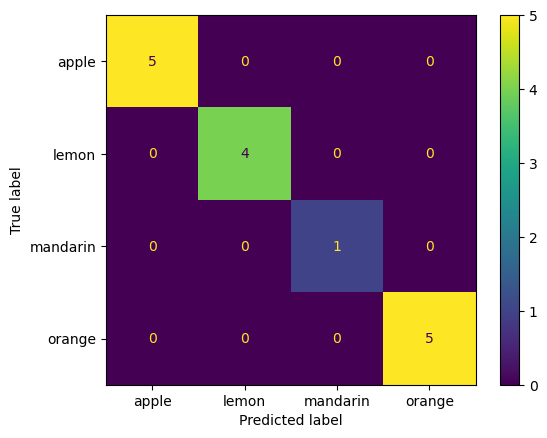

In [24]:
# Visualize prediction performance as a confusion matrix

# ConfusionMatrixDisplay.from_estimator(
#     estimator=____
#     X=____,
#     y=____
# )
### BEGIN SOLUTION
ConfusionMatrixDisplay.from_estimator(
    estimator=fruit_tune_grid,
    X=fruit_test_w_predictions.drop(columns=['fruit_name']),
    y=fruit_test_w_predictions['fruit_name']
)
### END SOLUTION

Hmmm... no mistakes on the test set... Why might that be?